In [12]:
import torch
import torch.nn as nn
import torch.distributions as dist
import numpy as np

In [13]:
num_samples = 1_000_000
print_every = 10

In [14]:
Z_0 = dist.Normal(torch.zeros(1), torch.ones(1))
values = torch.tensor([-2.0, 2.0])
probs = torch.tensor([0.5, 0.5])
Z_1 = torch.distributions.Categorical(probs=probs)

data_1 = Z_0.sample((num_samples,))
data_2 = values[Z_1.sample((num_samples,))].unsqueeze(1)
print(data_1.shape, data_2.shape)

torch.Size([1000000, 1]) torch.Size([1000000, 1])


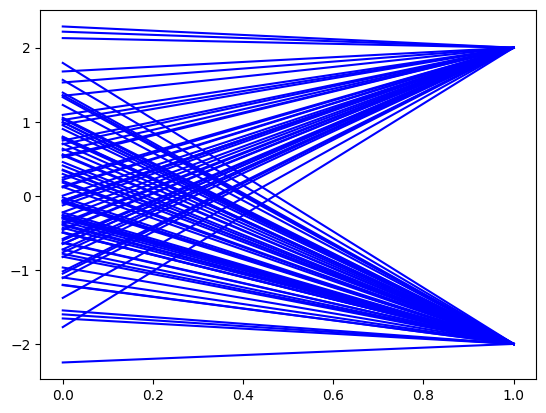

In [15]:
import matplotlib.pyplot as plt
delta_y = torch.cat([data_1[:100], data_2[:100]], dim=-1).T
plt.plot(delta_y, color='b')
plt.show()

In [16]:
time_dist = dist.uniform.Uniform(0, 1)

In [17]:
from torch.utils.data import DataLoader, TensorDataset
dset = TensorDataset(data_1.cpu(), data_2.cpu())
dldr = DataLoader(dset, batch_size=10_000, num_workers=7)

from random import randint
print(dset[randint(0,len(dset))])

(tensor([0.8315]), tensor([-2.]))


In [18]:
velocity_net = nn.Sequential(nn.Linear(5, 128),
                             nn.ReLU(inplace=True),
                             nn.Linear(128, 128),
                             nn.ReLU(inplace=True),
                             nn.Linear(128, 128),
                             nn.ReLU(inplace=True),
                             nn.Linear(128, 1)).to(torch.device('cuda:0'))

def schedule(time):
    return (torch.cos(torch.pi*time/2), torch.sin(torch.pi*time/2))

In [19]:
from torch.optim import Adam, SGD
loss = nn.MSELoss()
optimizer = Adam(velocity_net.parameters(), lr=1e-2, fused=True)

In [20]:
rolling_loss = 0
for epoch in range(10):
    for i, sample in enumerate(dldr):
        x_0, x_1 = sample
        time = time_dist.sample(x_0.shape)
        x_0 = torch.randn_like(x_0).to('cuda:0')
        x_1 = x_1.to('cuda:0')
        time = time.to('cuda:0')

        a_t, b_t = schedule(time)
        x_t = a_t * x_0 + b_t * x_1

        fourier_time = (torch.sin(torch.pi*time/2), torch.cos(torch.pi*time/2),
                        torch.sin(torch.pi*time/4), torch.cos(torch.pi*time/4))
        net_input = torch.cat((x_t,) + fourier_time, dim=-1)
        velocity = velocity_net(net_input)

        loss_value = loss(velocity, (x_1 - x_0))
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        rolling_loss += loss_value.item()

        if i%print_every==print_every-1:
            print(f'Loss: {rolling_loss/print_every:0.3f}, Velocity: {((velocity**2).mean())**0.5:0.3f}')
            rolling_loss = 0

Loss: 3.561, Velocity: 1.118
Loss: 2.522, Velocity: 1.645
Loss: 2.268, Velocity: 1.598
Loss: 2.127, Velocity: 1.586
Loss: 2.090, Velocity: 1.609
Loss: 2.066, Velocity: 1.649
Loss: 2.066, Velocity: 1.706
Loss: 2.074, Velocity: 1.661
Loss: 2.078, Velocity: 1.718
Loss: 2.038, Velocity: 1.617
Loss: 2.077, Velocity: 1.594
Loss: 2.047, Velocity: 1.582
Loss: 2.035, Velocity: 1.753
Loss: 2.013, Velocity: 1.727
Loss: 1.991, Velocity: 1.768
Loss: 2.012, Velocity: 1.656
Loss: 2.019, Velocity: 1.779
Loss: 1.994, Velocity: 1.681
Loss: 2.009, Velocity: 1.824
Loss: 1.971, Velocity: 1.688
Loss: 2.017, Velocity: 1.685
Loss: 2.007, Velocity: 1.816
Loss: 2.029, Velocity: 1.835
Loss: 1.998, Velocity: 1.720
Loss: 2.003, Velocity: 1.761
Loss: 2.034, Velocity: 1.821
Loss: 1.995, Velocity: 1.735
Loss: 2.016, Velocity: 1.633
Loss: 2.007, Velocity: 1.763
Loss: 1.995, Velocity: 1.728
Loss: 2.002, Velocity: 1.771
Loss: 1.995, Velocity: 1.737
Loss: 2.002, Velocity: 1.684
Loss: 1.989, Velocity: 1.835
Loss: 2.044, V

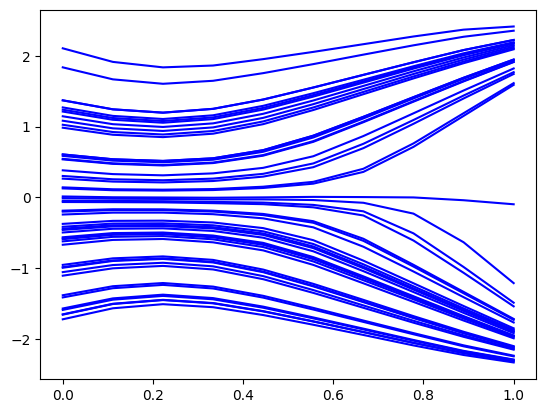

In [24]:
import matplotlib.pyplot as plt

# Generate trajectories from Z_0
n_trajectories = 50
n_steps = 10
bundle_0 = Z_0.sample((n_trajectories,)).squeeze()
bundle_t = bundle_0
data = torch.zeros((n_steps, n_trajectories))

velocity_net.eval()
with torch.no_grad():
    for t in range(n_steps):
        time = t/n_steps*torch.ones(n_trajectories)
        fourier_time = (torch.sin(torch.pi*time/2), torch.cos(torch.pi*time/2),
                        torch.sin(torch.pi*time/4), torch.cos(torch.pi*time/4))
        bundle_t_time = torch.stack((bundle_t,)+fourier_time, dim=-1)
        velocity = velocity_net(bundle_t_time.cuda())
        data[t] = bundle_t
        bundle_t += velocity.cpu()[:, 0]/n_steps

plt.plot(np.linspace(0, 1, n_steps), data, color='blue')

In [22]:
data_2 = data_1.to('cuda')
n_steps = 100

with torch.no_grad():
    for t in range(n_steps):
        time = t/n_steps*torch.ones((num_samples, 1), device='cuda:0')
        fourier_time = (torch.sin(torch.pi*time/2), torch.cos(torch.pi*time/2),
                        torch.sin(torch.pi*time/4), torch.cos(torch.pi*time/4))
        bundle_t_time = torch.cat((data_2,)+fourier_time, dim=-1)
        velocity = velocity_net(bundle_t_time)
        data_2 += velocity/n_steps
